In [6]:
path = "Outputs/Outputs_electricity_syn_0.5_testing/electricity/"


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
preds = np.load(path+'TRANS-Q-AR_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
preds.shape, trues.shape, inputs.shape
print("mse : ",mean_squared_error(trues.squeeze(),preds[...,8]),"mae: ",mean_absolute_error(trues.squeeze(),preds[...,8]))

mse :  9945.975 mae:  63.86992


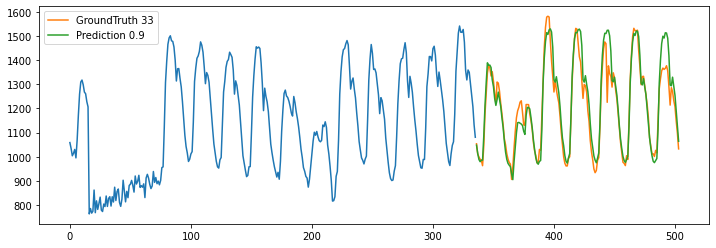

In [21]:
plt.rcParams['figure.figsize'] = (12,4)
c =33
x = np.arange(504)
a = 336
plt.figure()
plt.plot(x[:a],inputs[c])
# plt.show()
plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
#for i in range(1):
# plt.plot(x[a:],preds[c,:,0], label='Prediction '+str((0+1)/10))
# plt.plot(x[a:],preds[c,:,4], label='Prediction '+str((4+1)/10))
plt.plot(x[a:],preds[c,:,6], label='Prediction '+str((8+1)/10))
plt.legend()
plt.show()